In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm, trange
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_curve, roc_auc_score, auc
from sklearn.model_selection import ShuffleSplit

%matplotlib inline

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Concatenate, Input, concatenate, Activation
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from keras import backend as K

from sklearn.model_selection import train_test_split

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


In [3]:
# load the files
houselist = glob.glob('HousesDataset/*.jpg')

image_data = []
for fname in houselist:
    image_name = fname.split('\\')[1].split('.')[0]
    image_data.append((image_name, Image.open(fname)))
    pass

text_data = pd.read_csv('HousesDataset/HousesInfo.txt', sep=' ',
                        names=["nBeds", "nbaths", "area", "zipcode", "price"])

In [4]:
row, col = 200, 200
X11 = np.zeros((535, row, col, 3)).astype(int)
X12 = np.zeros((535, row, col, 3)).astype(int)
X13 = np.zeros((535, row, col, 3)).astype(int)
X14 = np.zeros((535, row, col, 3)).astype(int)
for name, image in tqdm(image_data):
    index, room = name.split('_')
    if room == "bathroom":
        X11[int(index) - 1, :, :] = np.array(image.resize((row, col)))
    elif room == "bedroom":
        X12[int(index) - 1, :, :] = np.array(image.resize((row, col)))
    elif room == "frontal":
        X13[int(index) - 1, :, :] = np.array(image.resize((row, col)))
    else:
        X14[int(index) - 1, :, :] = np.array(image.resize((row, col)))

100%|█████████████████████████████████████████████████████████████████████████████| 2140/2140 [00:17<00:00, 101.08it/s]


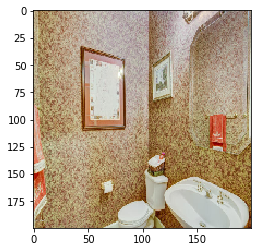

In [5]:
plt.imshow(X11[0])

In [6]:
text_array = np.zeros((535, 5))
for i, text in text_data.iterrows():
    text_array[i] = text.values

In [7]:
X2 = text_array[:, :3]
y = text_array[:, -1]
y_class = np.where(y > 700000, 1, 0)

In [8]:
shuffle = np.arange(len(y))
np.random.shuffle(shuffle)

X11 = X11[shuffle]
X12 = X12[shuffle]
X13 = X13[shuffle]
X14 = X14[shuffle]
X2 = X2[shuffle]
y_class = y_class[shuffle]

split_inedx = 430

x11_train = X11[:split_inedx]
x12_train = X12[:split_inedx]
x13_train = X13[:split_inedx]
x14_train = X14[:split_inedx]
x2_train = X2[:split_inedx]
y_train = y_class[:split_inedx]

x11_test = X11[split_inedx:]
x12_test = X12[split_inedx:]
x13_test = X13[split_inedx:]
x14_test = X14[split_inedx:]
x2_test = X2[split_inedx:]
y_test = y_class[split_inedx:]

x2_min = np.min(x2_train, axis=0)
x2_max = np.max(x2_train, axis=0)
x2_train = (x2_train - x2_min) / (x2_max - x2_min)
x2_test = (x2_test - x2_min) / (x2_max - x2_min)

In [24]:
# cnn model
def visual_model(input_layer):
    conv1 = Conv2D(8, kernel_size=(3, 3), activation='relu')(input_layer)
    bat1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bat1)
    conv2 = Conv2D(16, kernel_size=(3, 3), activation='relu')(pool1)
    bat2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(3, 3))(bat2)
    conv3 = Conv2D(32, kernel_size=(3, 3), activation='relu')(pool2)
    bat3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bat3)
    flat = Flatten()(pool3)
    x = Dense(16)(flat)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(0.5)(x)
    
    x = Dense(4)(x)
    x = Activation("sigmoid")(x)
    return x

In [25]:
def merged_model():
    # visual features (cnn)
    visual_input1 = Input(shape=(row, col, 3), name='visual_input1')
    visual1 = visual_model(visual_input1)

    visual_input2 = Input(shape=(row, col, 3), name='visual_input2')
    visual2 = visual_model(visual_input2)

    visual_input3 = Input(shape=(row, col, 3), name='visual_input3')
    visual3 = visual_model(visual_input3)

    visual_input4 = Input(shape=(row, col, 3), name='visual_input4')
    visual4 = visual_model(visual_input4)

    # textual features (mlp)
    textual_input = Input(shape=(3,), name='textual_input')
    textual_output = Dense(20, activation='relu')(textual_input)
    textual_output = BatchNormalization()(textual_input)

    # merge visual and textual layers
    x = keras.layers.concatenate([visual1, visual2, visual3, visual4, textual_output])
    # fully connectied
    x = Dense(10, activation='relu')(x)
    x = Dropout(0.5)(x)

    # output
    main_output = Dense(1, activation='sigmoid', name='main_output')(x)
    model = Model(inputs=[visual_input1, visual_input2, visual_input3, visual_input4, textual_input], outputs=main_output)
    return model

In [27]:
rs = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
rs.get_n_splits(X2)

print(rs)

y_hat = []
y_val_list = []

index = 0
for train_index, val_index in rs.split(y_train):
    print("Training on Fold: ",index+1)
    x11_tr = x11_train[train_index]
    x12_tr = x12_train[train_index]
    x13_tr = x13_train[train_index]
    x14_tr = x14_train[train_index]
    x2_tr = x2_train[train_index]
    y_tr = y_train[train_index]

    x11_val = x11_train[val_index]
    x12_val = x12_train[val_index]
    x13_val = x13_train[val_index]
    x14_val = x14_train[val_index]
    x2_val = x2_train[val_index]
    y_val = y_train[val_index]
    
    model = merged_model()
    model.compile(optimizer="adam",
                  loss={'main_output': 'binary_crossentropy'}, metrics={'main_output': ["accuracy"]})

    model.fit([x11_tr, x12_tr, x13_tr, x14_tr, x2_tr], y_tr,
              shuffle=True,
              epochs=30, 
              batch_size=100)
    
    y_hat.append(model.predict([x11_val, x12_val, x13_val, x14_val, x2_val]))
    y_val_list.append(y_val)
    
    metric = model.evaluate([x11_val, x12_val, x13_val, x14_val, x2_val], y_val)
    print("Val loss: {0}, Val acc: {1}".format(metric[0], metric[1]))
    print("======="*12, end="\n\n\n")
    index += 1

ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None)
Training on Fold:  1
Epoch 1/30
322/322 [==============================] - 30s 92ms/step - loss: 0.7433 - acc: 0.5745
Epoch 2/30
322/322 [==============================] - 2s 5ms/step - loss: 0.6323 - acc: 0.6708
Epoch 3/30
322/322 [==============================] - 2s 5ms/step - loss: 0.5804 - acc: 0.6957
Epoch 4/30
322/322 [==============================] - 2s 5ms/step - loss: 0.5683 - acc: 0.7205
Epoch 5/30
322/322 [==============================] - 2s 5ms/step - loss: 0.5175 - acc: 0.7547
Epoch 6/30
322/322 [==============================] - 2s 5ms/step - loss: 0.5406 - acc: 0.7578
Epoch 7/30
322/322 [==============================] - 2s 5ms/step - loss: 0.5195 - acc: 0.7826
Epoch 8/30
322/322 [==============================] - 2s 5ms/step - loss: 0.4848 - acc: 0.7640
Epoch 9/30
322/322 [==============================] - 2s 5ms/step - loss: 0.4638 - acc: 0.7795
Epoch 10/30
322/322 [===========================

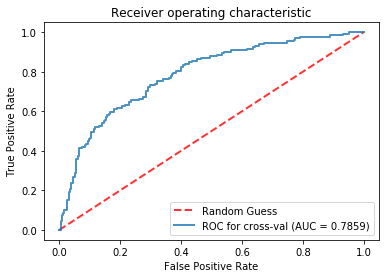

In [28]:
# combine k folds
y_hat_total = np.concatenate(y_hat)
y_val_total = np.concatenate(y_val_list)

fpr, tpr, thresholds = roc_curve(y_val_total, y_hat_total)
roc_auc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Random Guess', alpha=.8)

plt.plot(fpr, tpr,
         label='ROC for cross-val (AUC = {:.4})'.format(roc_auc),
         lw=2, alpha=.8)

plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [26]:
# actual model
model = merged_model()
model.compile(optimizer="adam",
              loss={'main_output': 'binary_crossentropy'}, metrics={'main_output': ["accuracy"]})

model.fit([x11_train, x12_train, x13_train, x14_train, x2_train], y_train,
          shuffle=True,
          epochs=30, 
          batch_size=100)

KeyboardInterrupt: 

In [12]:
y_hat = model.predict([x11_test, x12_test, x13_test, x14_test, x2_test])

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
print("roc: ", roc_auc_score(y_test, y_hat))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("threshold: ", optimal_threshold)

roc:  0.8053539019963702
threshold:  0.13343039


In [14]:
# for y1, y2 in zip(y_class[split_inedx:], np.where(y_hat.ravel() > optimal_threshold, 1, 0)):
#     print("y: ",y1, ", y_hat: ", y2)